In [1]:
import numpy as np 
import math
from scipy.stats import norm,laplace
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from collections import Counter, OrderedDict
import copy 
import pandas as pd
import time
import datetime

import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
np.random.seed(7)

Using TensorFlow backend.


In [2]:
Dataset = r'../15minute_data_newyork/15minute_data_newyork.csv'
fulldata = pd.read_csv(Dataset) 

# Data Preprocessing

In [3]:
#only important index so far are the dataid - what house it belongs to, local_15mins - the time, and grid data
data=fulldata[['dataid','local_15min','grid']]
sorteddata=data.sort_values(by = ['dataid', 'local_15min'])
ids=sorteddata['dataid'].unique().tolist()

In [4]:
housing_data = []
def convertDate(d):
    "helper function to remove time zone string"
    d = pd.to_datetime(d[:-3])
    return d 

for i in range(len(ids)):
    housing_data.append(sorteddata.loc[sorteddata.dataid==ids[i]])
    housing_data[i] = housing_data[i].reset_index().drop(columns=['index'])
    housing_data[i]['local_15min'] = housing_data[i]['local_15min'].apply(convertDate)
    #Convert datetimes to ints for faster ploting 
    housing_data[i]['15min_ints'] =  housing_data[i]['local_15min'].map(mdates.date2num)

In [5]:
def create_dataset(dataset, look_back=1, look_ahead=None):
	"function for creating dataset for model, X being the known data, and Y being target data"
	if look_ahead is None:
		look_ahead = look_back
	dataX, dataY = [], []
	for i in range(len(dataset)-2*look_back):
		dataX.append(dataset[i:(i+look_back), 0])
		if look_ahead == 0:
			dataY.append(dataset[i + look_back, 0])
		else:
			dataY.append(dataset[(i+look_back):(i+look_back+look_ahead), 0])
		
	return np.array(dataX), np.array(dataY)


In [6]:
#set updataframe = housing_data[0]['grid']
dataframe = housing_data[0]['grid']
dataset = np.matrix(dataframe.values).transpose()
dataset = dataset.astype('float32')

In [7]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:,:]

In [9]:
# reshape into X=t and Y=t+look_back
look_back = 96 #(60mins/15min)*24 hours
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [10]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [11]:
model = load_model('../models/D_0house_model_1_25_adam.h5')
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dropout_50 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 96)                6240      
Total params: 23,136
Trainable params: 23,136
Non-trainable params: 0
_________________________________________________________________


# Data Analysis
## Average Day

In [12]:
#verify time is correct
time = housing_data[0]['local_15min']


In [13]:
#diff in time
print(time[0])
print(time[look_back])

2019-05-01 00:00:00
2019-05-02 00:00:00


In [14]:
#get how many complete days are in the dataset and preint how many complete day samples are there
fulldays=len(dataframe)//look_back
print(look_back*fulldays)

17568


In [15]:
#convert to numpy for easier processing
grid_data=dataframe.to_numpy()
grid_data.shape

(17663,)

In [16]:
#convert to matrix, remove non full days
grid_day_matrix=grid_data[:(look_back*fulldays)].reshape(-1, 96)
#avg house0 grid data 
avg_house0_grid=np.mean(grid_day_matrix, axis=0)
grid_day_matrix.shape

(183, 96)

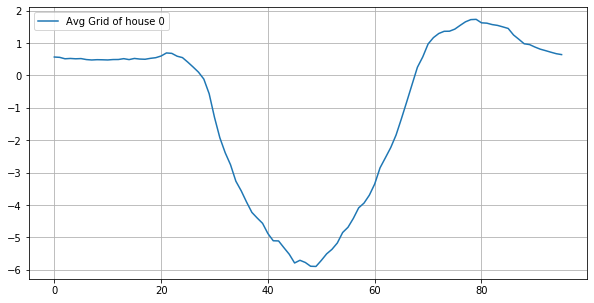

In [17]:
plt.figure(figsize=(10,5))
plt.plot(avg_house0_grid, label= 'Avg Grid of house 0' )
plt.grid(True)
plt.legend()

In [18]:
#predict on new housing data
house0X, house0Y = create_dataset(dataset, look_back)
house0X = house0X.reshape(house0X.shape[0], house0X.shape[1],1)
house0Predict = model.predict(house0X)

house0Predict = scaler.inverse_transform(house0Predict)
house0Y = scaler.inverse_transform(house0Y)


In [19]:
#RMSE score
ttrain0Score = math.sqrt(mean_squared_error(house0Y, house0Predict))
print('Train Score: %.2f RMSE' % (ttrain0Score))


Train Score: 1.77 RMSE


In [20]:
#get avg prediction per day
pred_house0_matrix=house0Predict[::look_back]
pred_house0_grid=np.mean(pred_house0_matrix, axis=0)

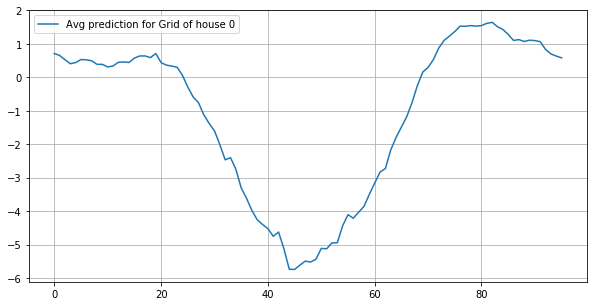

In [21]:
plt.figure(figsize=(10,5))
plt.plot(pred_house0_grid, label= 'Avg prediction for Grid of house 0' )
plt.grid(True)
plt.legend()

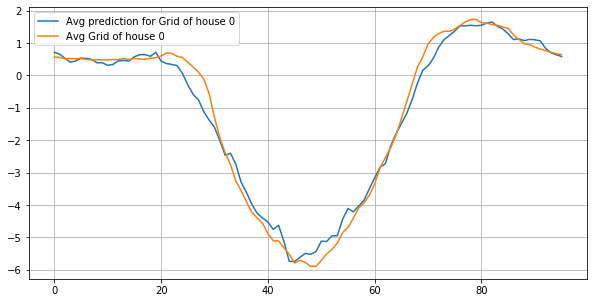

In [22]:
#plot both of them together
plt.figure(figsize=(10,5))
plt.plot(pred_house0_grid , label= 'Avg prediction for Grid of house 0')
plt.plot(avg_house0_grid, label= 'Avg Grid of house 0' )
plt.grid(True)
plt.legend()

In [23]:
ttrain0Score = math.sqrt(mean_squared_error(pred_house0_grid, avg_house0_grid))
print('Train Score: %.2f RMSE' % (ttrain0Score))

Train Score: 0.32 RMSE


## Error of model 

In [24]:
#get error
abs_error = abs(avg_house0_grid-pred_house0_grid)
error = (avg_house0_grid-pred_house0_grid)
# abs_error = abs(avg_house0_grid-pred_house0_grid)/avg_house0_grid
# error = abs_error
# error = (avg_house0_grid-pred_house0_grid)

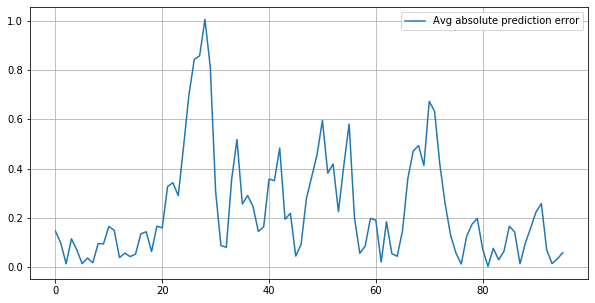

In [25]:
plt.figure(figsize=(10,5))
plt.plot(abs_error, label= 'Avg absolute prediction error')
plt.grid(True)
plt.legend()

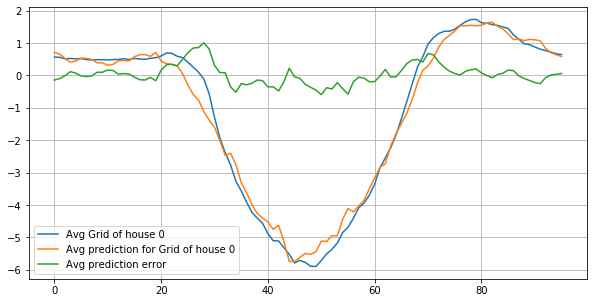

In [26]:
plt.figure(figsize=(10,5))
plt.plot(avg_house0_grid, label= 'Avg Grid of house 0' )
plt.plot(pred_house0_grid, label= 'Avg prediction for Grid of house 0' )
plt.plot(error, label= 'Avg prediction error')
plt.legend()
plt.grid(True)


In [27]:
#percent error
f_h= abs(pred_house0_grid-avg_house0_grid)/avg_house0_grid
f_h = np.mean(f_h)
f_h*100



11.860469846794937

In [28]:
np.mean(avg_house0_grid)

-1.0786842554644807

In [29]:
avg_house0_grid

array([ 0.56593989,  0.55592896,  0.51157377,  0.52153552,  0.51130055,
        0.51783607,  0.4873388 ,  0.47476503,  0.48363934,  0.48083607,
        0.47548087,  0.48776503,  0.48937158,  0.51537705,  0.48643716,
        0.52179781,  0.503     ,  0.49678142,  0.52532787,  0.54561749,
        0.59721858,  0.69164481,  0.67862842,  0.59112568,  0.54779235,
        0.40753005,  0.25657923,  0.09896175, -0.11464481, -0.5677377 ,
       -1.29744809, -1.92521858, -2.38616393, -2.75854645, -3.26551913,
       -3.56179781, -3.90779781, -4.2281694 , -4.4023224 , -4.56519672,
       -4.88153552, -5.10320765, -5.10886339, -5.3174153 , -5.51972678,
       -5.78888525, -5.70587432, -5.77306557, -5.8898306 , -5.89585792,
       -5.71064481, -5.50752459, -5.36794536, -5.17236612, -4.84842077,
       -4.68712022, -4.41319672, -4.08773224, -3.94065574, -3.69604918,
       -3.35237158, -2.85359563, -2.54387432, -2.22877596, -1.84200546,
       -1.33920219, -0.8152623 , -0.28072678,  0.24966667,  0.56

In [30]:
np.mean(abs(avg_house0_grid))

2.059905225409836

### Error Percentage
<!-- ##Test -->


In [31]:
#get std of error
errorstd = np.std(error)
errorstd

0.3172669309853082

In [32]:
np.mean(abs(error))

0.23456542232780722

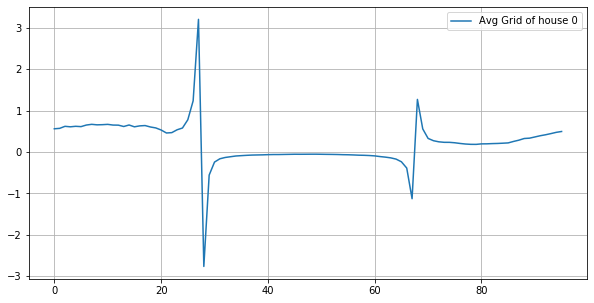

In [33]:
#plot perectage error
error_percentage=errorstd/avg_house0_grid
plt.figure(figsize=(10,5))
plt.plot(error_percentage, label= 'Avg Grid of house 0' )
plt.legend()
plt.grid(True)

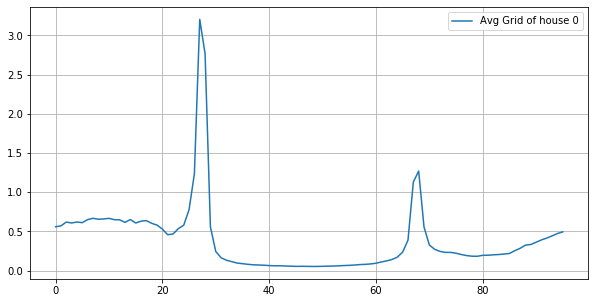

In [34]:
#plot absolute error
abs_error_percentage=errorstd/abs(avg_house0_grid)
plt.figure(figsize=(10,5))
plt.plot(abs_error_percentage, label= 'Avg Grid of house 0' )
plt.legend()
plt.grid(True)

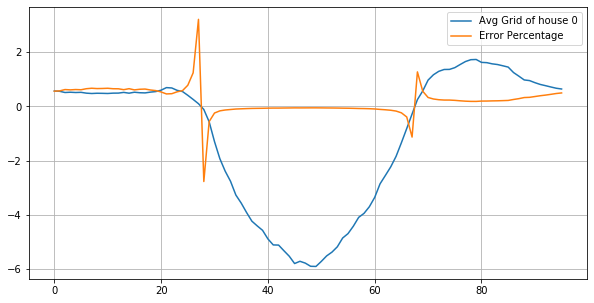

In [35]:
plt.figure(figsize=(10,5))
plt.plot(avg_house0_grid, label= 'Avg Grid of house 0' )
# plt.plot(pred_house0_grid, label= 'Avg prediction for Grid of house 0' )
plt.plot(error_percentage, label= 'Error Percentage')
# plt.plot(abs_error_percentage, label= 'Avg Grid of house 0' )
plt.legend()
plt.grid(True)

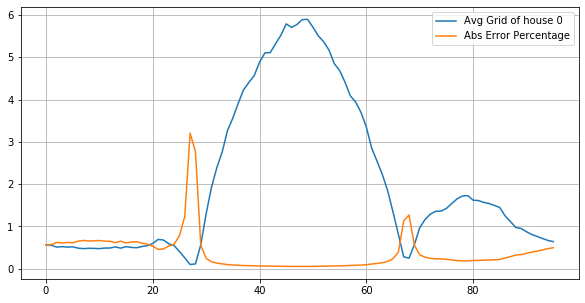

In [36]:
plt.figure(figsize=(10,5))
plt.plot(abs(avg_house0_grid), label= 'Avg Grid of house 0' )
# plt.plot(pred_house0_grid, label= 'Avg prediction for Grid of house 0' )
# plt.plot(error_penctage, label= 'Error Percentage')
plt.plot(abs_error_percentage, label= 'Abs Error Percentage' )
plt.legend()
plt.grid(True)

# Distribution of error

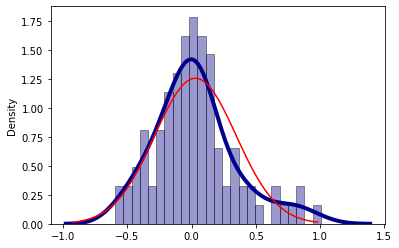

In [37]:
#distro of the data vs normal 

mu = np.mean(error)
variance = np.var(error)
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

sns.distplot(error, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.plot(x, norm.pdf(x, mu, sigma), color ='r')

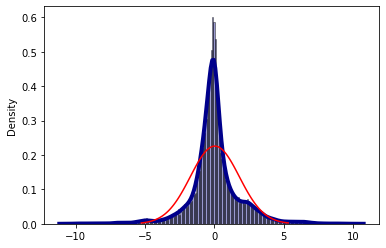

In [38]:
fullpredict =house0Predict[::look_back].reshape(182*96)
comparetrue= house0Y[::look_back].reshape(182*96)
fullerror = comparetrue - fullpredict

#distro of the data vs normal 

mu = np.mean(fullerror)
variance = np.var(fullerror)
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

sns.distplot(fullerror, hist=True, kde=True, 
             bins="auto", color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.plot(x, norm.pdf(x, mu, sigma), color ='r')

In [39]:
mean, var = laplace.stats(moments='mv')
mean

array(0.)

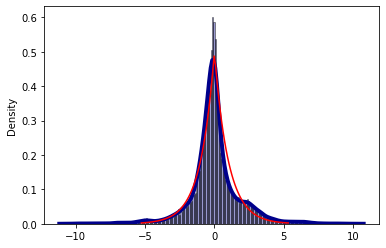

In [40]:
#distro of the data vs normal 

mu = np.mean(fullerror)
variance = np.var(fullerror)
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

sns.distplot(fullerror, hist=True, kde=True, 
             bins="auto", color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
# plt.plot(x, norm.pdf(x, mu, sigma), color ='r')
plt.plot(x, laplace.pdf(x), color ='r')

## Uncertainty of model 
https://fairyonice.github.io/Measure-the-uncertainty-in-deep-learning-models-using-dropout.html

In [41]:
#Set up X 
uncertaintlytestX=house0X[::look_back]
uncertaintlytestX.shape

(182, 96, 1)

In [42]:
house0Y.shape

(17471, 96)

In [43]:
class KerasDropoutPrediction(object):
    "class for collecting predictions"
    def __init__(self,model):
        self.f = K.function(
                [model.layers[0].input, 
                 K.learning_phase()],
                [model.layers[-1].output])
    def predict(self,x, n_iter=10):
        result = []
        for _ in range(n_iter):
            buf=self.f([x , 1])
            # print(np.asarray(buf).shape)
            result.append(buf)
        result = np.array(result).reshape(n_iter,len(x),96).T
        return result
Nsim = look_back*10
kdp = KerasDropoutPrediction(model)
result = kdp.predict(uncertaintlytestX, Nsim)

In [44]:
result.shape

(96, 182, 960)

In [45]:
#max and min of the each prediction per 15mins (each 15 mins per day)x(full data set)x(number of prediction) -> (each 15 mins per day)x(full data set) 
maxypredict = np.amax(result,axis=2)
maxypredict=scaler.inverse_transform(maxypredict)
minypredict = np.amin(result,axis=2)
minypredict=scaler.inverse_transform(minypredict)

In [46]:

# avg per day (each 15 mins per day)x(full data set) -> (each 15 mins per day)

maxy_avg_predict = np.mean(maxypredict, axis = 1)
miny_avg_predict = np.mean(minypredict, axis = 1)

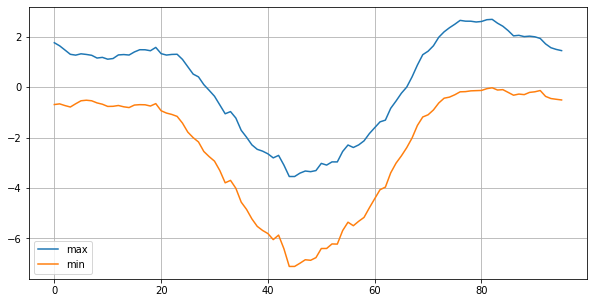

In [47]:
#max and min of each prediction
plt.figure(figsize=(10,5))
plt.plot(maxy_avg_predict, label='max')
plt.plot(miny_avg_predict, label='min')
plt.grid(True)
plt.legend()

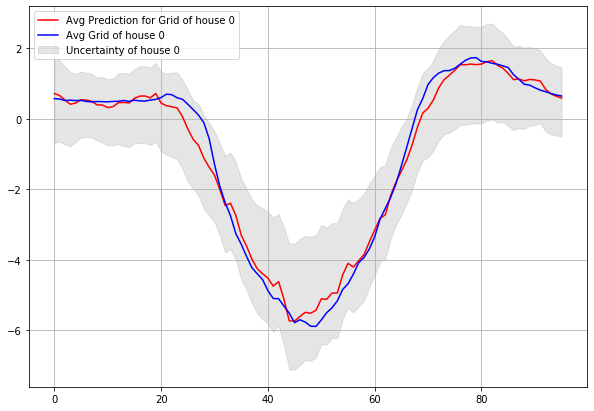

In [48]:
#Uncertainty
x = np.arange(96)
plt.figure(figsize=(10,7))
plt.plot(x, pred_house0_grid, 'r', label='Avg Prediction for Grid of house 0' )
plt.plot(avg_house0_grid, 'b', label='Avg Grid of house 0')
plt.fill_between(x, miny_avg_predict,maxy_avg_predict, color='gray', alpha=0.2, label='Uncertainty of house 0')
plt.grid(True)
plt.legend()

# Abs Day


In [49]:
dataframe = housing_data[0]['grid']
grid_data=dataframe.to_numpy()
#convert to matrix, remove non full days
grid_day_matrix=grid_data[:(look_back*fulldays)].reshape(-1, 96)
abs_grid_day_matrix = abs(grid_day_matrix)
#avg house0 grid data 
abs_avg_house0_grid=np.mean(abs_grid_day_matrix, axis=0)


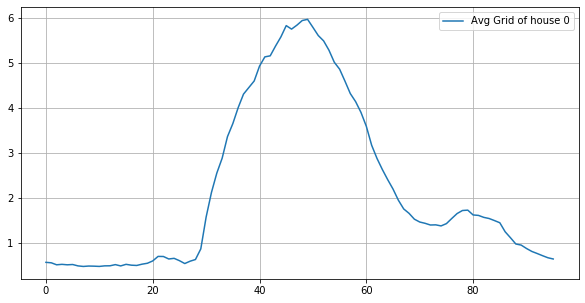

In [50]:
plt.figure(figsize=(10,5))
plt.plot(abs_avg_house0_grid, label= 'Avg Grid of house 0' )
plt.grid(True)
plt.legend()

In [51]:
np.mean(abs_avg_house0_grid)

2.2060068875227685